In [32]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import datetime


In [14]:
run_name ='harts_+4K_WY23'
harts = xr.open_dataset('../model/output/harts_pass/template_output_'+run_name+'_timestep.nc')

In [15]:
harts

<xarray.Dataset> Size: 45MB
Dimensions:                    (time: 6889, hru: 1, gru: 1, midToto: 109,
                                midSoil: 9, ifcToto: 110)
Coordinates:
  * time                       (time) datetime64[ns] 55kB 2022-10-01 ... 2023...
  * hru                        (hru) int64 8B 1001
  * gru                        (gru) int64 8B 1001
Dimensions without coordinates: midToto, midSoil, ifcToto
Data variables: (12/51)
    pptrate                    (time, hru) float64 55kB ...
    airtemp                    (time, hru) float64 55kB ...
    SWRadAtm                   (time, hru) float64 55kB ...
    LWRadAtm                   (time, hru) float64 55kB ...
    averageInstantRunoff       (time, gru) float64 55kB ...
    averageRoutedRunoff        (time, gru) float64 55kB ...
    ...                         ...
    scalarSoilBaseflow         (time, hru) float64 55kB ...
    scalarAquiferBaseflow      (time, hru) float64 55kB ...
    scalarTotalRunoff          (time, hru) float64 55kB ...
    scalarNetRadiation         (time, hru) float64 55kB ...
    hruId                      (hru) int64 8B ...
    gruId                      (gru) int64 8B ...
Attributes: (12/34)
    summaVersion:     v3.1.2
    buildTime:        Fri 10 Feb 2023 02:32:58 PM UTC
    gitBranch:        master-0-gfa9adf8
    gitHash:          fa9adf808229a45085defdc2bb8ef05836b9b3aa
    soilCatTbl:       ROSETTA
    vegeParTbl:       MODIFIED_IGBP_MODIS_NOAH
    ...               ...
    compaction:       anderson
    thCondSnow:       smnv2000
    thCondSoil:       funcSoilWet
    spatial_gw:       localColumn
    subRouting:       timeDlay
    snowDenNew:       pahaut_76

In [16]:
import numpy as np
import shapely
import geopandas as gpd
from cartopy.feature import NaturalEarthFeature


def justify(a, invalid_val=np.nan, axis=1, side='right'):
    """
    Justifies a 2D array
    Courtesy: https://stackoverflow.com/questions/44558215/python-justifying-numpy-array/44559180#44559180

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """
    if invalid_val is np.nan:
        mask = ~np.isnan(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    out = np.full(a.shape, invalid_val)
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

In [17]:
depth = harts.isel(hru=0)['iLayerHeight']
temp = harts.isel(hru=0)['mLayerTemp']
frac_wat = harts.isel(hru=0)['mLayerVolFracWat']



In [18]:
def layers(var, depth, ax=None, colormap='viridis', plot_soil=True,
           plot_snow=True, variable_range=None, add_colorbar=True,
           line_kwargs={}, cbar_kwargs={}):
    """
    Makes a layers plot. Example usage:

    ::

        import pysumma.plotting as psp
        time_range = slice('10-29-2000', '04-30-2001')
        depth    = ds.isel(hru=0).sel(time=time_range)['iLayerHeight']
        temp     = ds.isel(hru=0).sel(time=time_range)['mLayerTemp']
        psp.layers(temp, depth)

    Parameters
    ----------
    var: xr.DataArray
        The variable holding the data to plot.
        Typically begins with ``mLayer``.
    depth: xr.DataArray
        The variable defining the depths of the interfaces
        of each layer. Typically should be ``iLayerHeight``
    ax: Axes
        The axis to plot on. If none is given, a new axis
        will be created
    colormap: string, default='viridis'
        The colormap to use
    plot_soil: boolean, default=True
        Whether to plot the soil domain
    plot_snow: boolean, default=True
        Whether to plot the snow domain
    variable_range: List[float], default=variable range
        The range of numerical values to use. Must be two numbers.
    add_colorbar: boolean, default=True
        Whether to add a colorbar
    line_kwargs: Dict, default={}
        Keyword arguments to pass to ax.vlines.
        These draw the individual layers.
    cbar_kwargs: Dict, default={}
        Keyword arguments to draw the colorbar.
        They are passed directly to plt.colorbar.
    """
    # Preprocess the data
    vmask = var != -9999
    dmask = depth != -9999
    depth.values = justify(depth.where(dmask).values)
    var.values = justify(var.where(vmask).values)
    lo_depth = depth.where(depth > 0).T
    hi_depth = depth.where(depth < 0).T
    if plot_soil and not plot_snow:
        var = var.where((depth > 0).values[:,:-1]).T
    elif plot_snow and not plot_soil:
        var = var.where((depth < 0).values[:,:-1]).T
    else:
        var = var.T
    time = depth.time.values

    # Map colors to full range of data
    if variable_range is not None:
        assert len(variable_range) == 2, 'variable_range must have 2 values!'
        norm = plt.Normalize(variable_range[0], variable_range[1])
    else:
        norm = plt.Normalize(np.nanmin(var), np.nanmax(var))
    cmap = mpl.cm.get_cmap(colormap)
    rgba = cmap(norm(var))

    # Create axes if needed
    if not ax:
        fig, ax = plt.subplots(figsize=(18,8))

    # Plot soil layers - need to reverse because we plot bottom down
    if plot_soil:
        for l in lo_depth.ifcToto.values[:-1][::-1]:
            y = lo_depth[l]
            y[np.isnan(y)] = 0
            ax.vlines(time, ymin=-y, ymax=0, color=rgba[l], **line_kwargs)

    # Plot snow layers - plot top down
    if plot_snow:
        for l in hi_depth.ifcToto.values[:-1]:
            y = hi_depth[l]
            y[np.isnan(y)] = 0
            if (y != 0).any():
                ax.vlines(time, ymin=0, ymax=-y, color=rgba[l], **line_kwargs)

    # Add the colorbar
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(var.values.flatten())
    try:
        label = var.long_name
    except:
        label = var.name
    if 'label' not in cbar_kwargs.keys():
        cbar_kwargs['label'] = label
    if 'ax' not in cbar_kwargs.keys():
        cbar_kwargs['ax'] = ax
    if add_colorbar:
        plt.gcf().colorbar(mappable, **cbar_kwargs)
    return ax, mappable

In [19]:
# layers(frac_wat, depth, variable_range=[0, 0.7], plot_soil=False, add_colorbar=True)
# layers(temp, depth, plot_soil=False, add_colorbar=True)

# harts['scalarSnowDepth'].plot(color='red', linewidth=2)

In [20]:
var = harts.isel(hru=0)['mLayerVolFracWat']
temp = harts.isel(hru=0)['mLayerTemp']
vmask = var != -9999
dmask = depth != -9999
tmask = temp != -9999
depth.values = justify(depth.where(dmask).values)
var.values = justify(var.where(vmask).values)
temp.values = justify(temp.where(tmask).values)
# Filter values that are greater than or equal to 0.55
filtered = var.where(var >= 0.55)

# Find the layers that have at least one such value
layers = filtered.any(dim='time')

# Count the number of such layers
count = layers.sum().values

print(f"Number of unique layers with a value greater than or equal to 0.55 at any point in time: {count}")

Number of unique layers with a value greater than or equal to 0.55 at any point in time: 109


In [21]:
# Calculate the average at all layers
average = temp.mean(dim='midToto')

# Filter var where the average is less than 273.15
filtered_var = var.where(average < 273)

# Calculate the vertical derivative
derivative = filtered_var.diff(dim='midToto')

# Initialize an empty list to store the counts
counts = []

# Loop over the 'time' dimension
for t in var.time.values:
    # Select the derivative for the current timestep
    derivative_t = derivative.sel(time=t)

    # Filter values that are greater than or equal to 0.2 or less than or equal to -0.2
    # filtered = derivative_t.where((derivative_t >= 0.1) | (derivative_t <= -0.1))
    filtered = derivative_t.where(derivative_t >= 0.1)

    # Count the number of layers with at least one such value
    count = np.isfinite(filtered).sum().values

    # Append the count to the list
    counts.append(count)

# Convert the list to a numpy array
counts = np.array(counts)

print(f"Number of layers with a vertical derivative of at least 0.2 for each timestep: {counts}")

Number of layers with a vertical derivative of at least 0.2 for each timestep: [0 0 0 ... 0 0 0]


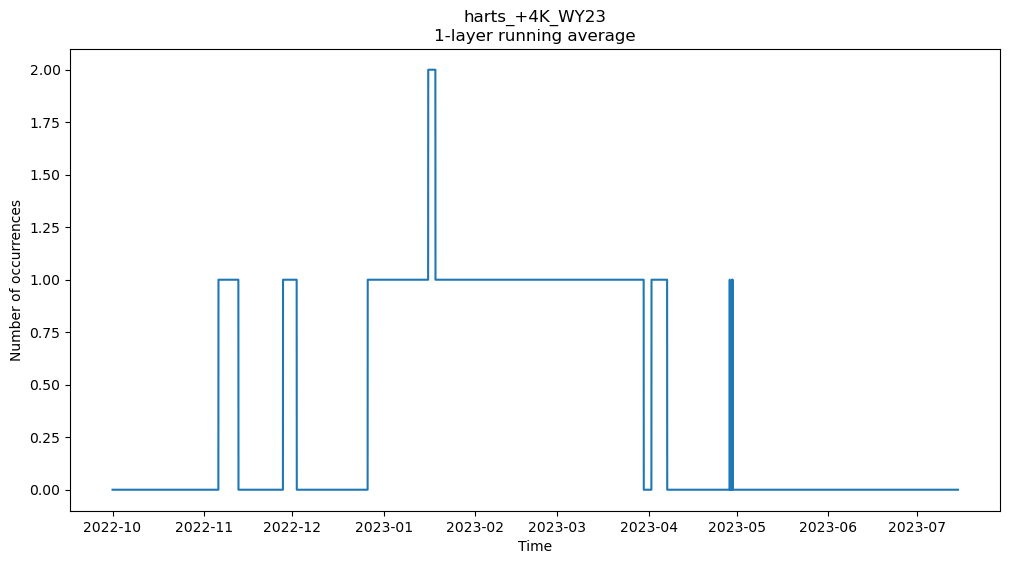

In [22]:
# Create a figure and an axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the timeseries
ax.plot(var.time.values, counts)

# Set the labels
ax.set_xlabel('Time')
ax.set_ylabel('Number of occurrences')
ax.set_title(run_name+'\n1-layer running average')

# Show the plot
plt.show()

## Rolling avg of 3 layers

In [23]:
# Calculate the 3-layer running average
average = var.rolling(midToto=2, center=True).mean()

# Calculate the vertical derivative
derivative = average.diff(dim='midToto')

# Initialize an empty list to store the counts
counts = []

# Loop over the 'time' dimension
for t in var.time.values:
    # Select the derivative for the current timestep
    derivative_t = derivative.sel(time=t)

    # Filter values that are greater than or equal to 0.2 or less than or equal to -0.2
    filtered = derivative_t.where((derivative_t >= 0.1) | (derivative_t <= -0.1))

    # Count the number of layers with at least one such value
    count = np.isfinite(filtered).sum().values

    # Append the count to the list
    counts.append(count)

# Convert the list to a numpy array
counts = np.array(counts)

print(f"Number of layers with a vertical derivative of at least 0.2 for each timestep: {counts}")

Number of layers with a vertical derivative of at least 0.2 for each timestep: [0 0 0 ... 0 0 0]


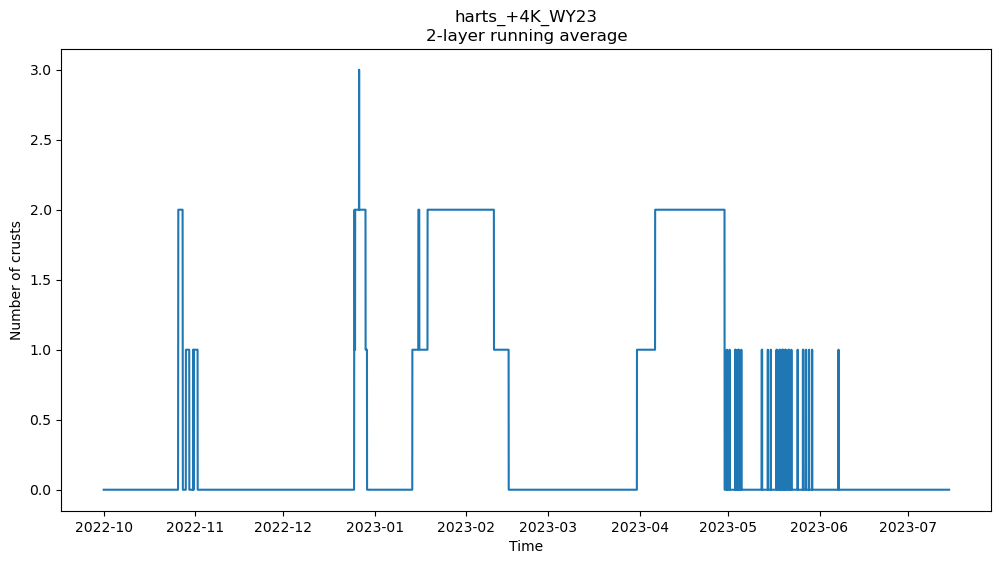

In [24]:
# Create a figure and an axes
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the timeseries
ax.plot(var.time.values, counts)

# Set the labels
ax.set_xlabel('Time')
ax.set_ylabel('Number of crusts')
ax.set_title(run_name+'\n2-layer running average')

# Show the plot
plt.show()

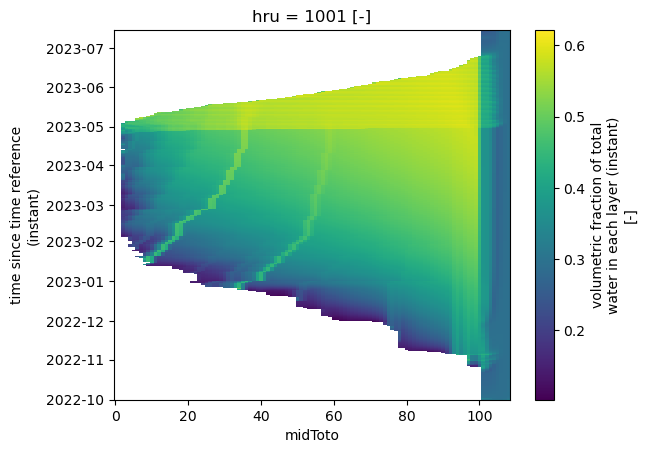

In [25]:
average.plot()

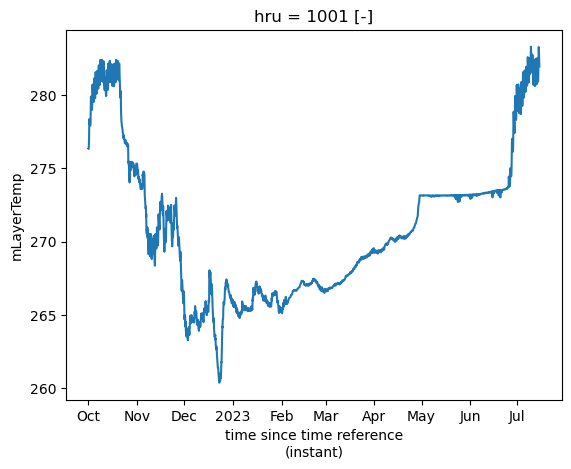

In [26]:
# Calculate the average at all layers
average = temp.mean(dim='midToto')

# Plot the average along the time axis
average.plot()

In [27]:
run_name ='harts_+4K_WY23'
harts = xr.open_dataset('../model/output/harts_pass/template_output_'+run_name+'_timestep.nc')

depth = harts.isel(hru=0)['iLayerHeight']
var = harts.isel(hru=0)['mLayerVolFracWat']
temp = harts.isel(hru=0)['mLayerTemp']
vmask = var != -9999
dmask = depth != -9999
tmask = temp != -9999
depth.values = justify(depth.where(dmask).values)
var.values = justify(var.where(vmask).values)
temp.values = justify(temp.where(tmask).values)

# Calculate the average at all layers
average = temp.mean(dim='midToto')

# Filter var where the average is less than 273.15
filtered_var = var.where(average < 273)

# Calculate the vertical derivative
derivative = filtered_var.diff(dim='midToto')

# Initialize an empty list to store the counts
counts = []

# Loop over the 'time' dimension
for t in var.time.values:
    # Select the derivative for the current timestep
    derivative_t = derivative.sel(time=t)

    # Filter values that are greater than or equal to 0.2 or less than or equal to -0.2
    # filtered = derivative_t.where((derivative_t >= 0.1) | (derivative_t <= -0.1))
    filtered = derivative_t.where(derivative_t >= 0.1)

    # Count the number of layers with at least one such value
    count = np.isfinite(filtered).sum().values

    # Append the count to the list
    counts.append(count)

# Convert the list to a numpy array
counts = np.array(counts)

In [47]:
crust_days = counts.sum()/24
mean_crusts = counts.mean()
mean_crusts

0.39439686456670053

In [39]:
# Define the coordinates
model_run = ['current', '+1K', '+2K', '+3K', '+4K', '+5K', '+6K']
site = ['harts', 'salmon']
time = pd.date_range('2000', '2024', freq='YS')

# Create a 3D numpy array with the shape (time, runs, sites)
data = np.full((len(time), len(model_run), len(site)), np.nan)

# Create the Dataset with two variables
ds = xr.Dataset(
    data_vars={
        'mean_crusts': (('time', 'model_run', 'site'), data),
        'crust_days': (('time', 'model_run', 'site'), data)
    },
    coords={
        'time': time,
        'model_run': model_run,
        'site': site
    }
)

ds

<xarray.Dataset> Size: 6kB
Dimensions:      (time: 25, model_run: 7, site: 2)
Coordinates:
  * time         (time) datetime64[ns] 200B 2000-01-01 2001-01-01 ... 2024-01-01
  * model_run    (model_run) <U7 196B 'current' '+1K' '+2K' ... '+5K' '+6K'
  * site         (site) <U6 48B 'harts' 'salmon'
Data variables:
    mean_crusts  (time, model_run, site) float64 3kB nan nan nan ... nan nan nan
    crust_days   (time, model_run, site) float64 3kB nan nan nan ... nan nan nan

In [33]:
# Split the string at the underscores
parts = run_name.split("_")

# Extract the parts
site = parts[0]
model_run = parts[1]

# Extract the year and convert it to a datetime
year_str = parts[2][2:]  # Remove the 'WY' prefix
year = int(year_str) + 2000  # Convert to an integer and add 2000
date = datetime.datetime(year, 1, 1)  # Create a datetime object for the first day of the year

In [48]:
# Assign a value to the 'crust_days' variable at the specified coordinates
ds['crust_days'].loc[dict(time=date, model_run=model_run, site=site)] = crust_days

# Assign a value to the 'mean_crusts' variable at the specified coordinates
ds['mean_crusts'].loc[dict(time=date, model_run=model_run, site=site)] = mean_crusts

In [45]:
ds.to_netcdf('/Users/clintonalden/Documents/Research/summa_work/analysis/crust_stats.nc')

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import datetime
import os

def justify(a, invalid_val=np.nan, axis=1, side='right'):
    """
    Justifies a 2D array
    Courtesy: https://stackoverflow.com/questions/44558215/python-justifying-numpy-array/44559180#44559180

    Parameters
    ----------
    A : ndarray
        Input array to be justified
    axis : int
        Axis along which justification is to be made
    side : str
        Direction of justification. It could be 'left', 'right', 'up', 'down'
        It should be 'left' or 'right' for axis=1 and 'up' or 'down' for axis=0.

    """
    if invalid_val is np.nan:
        mask = ~np.isnan(a)
    else:
        mask = a!=invalid_val
    justified_mask = np.sort(mask,axis=axis)
    if (side=='up') | (side=='left'):
        justified_mask = np.flip(justified_mask,axis=axis)
    out = np.full(a.shape, invalid_val)
    if axis==1:
        out[justified_mask] = a[mask]
    else:
        out.T[justified_mask.T] = a.T[mask.T]
    return out

run_name = input("Enter the run name: ")
print('**********')
print(run_name)
print('**********')
harts = xr.open_dataset('/Users/clintonalden/Documents/Research/summa_work/model/output/harts_pass/template_output_'+run_name+'_timestep.nc')

depth = harts.isel(hru=0)['iLayerHeight']
var = harts.isel(hru=0)['mLayerVolFracWat']
temp = harts.isel(hru=0)['mLayerTemp']
vmask = var != -9999
dmask = depth != -9999
tmask = temp != -9999
depth.values = justify(depth.where(dmask).values)
var.values = justify(var.where(vmask).values)
temp.values = justify(temp.where(tmask).values)

# Calculate the average at all layers
average = temp.mean(dim='midToto')

# Filter var where the average is less than 273.15
filtered_var = var.where(average < 273)

# Calculate the vertical derivative
derivative = filtered_var.diff(dim='midToto')

# Initialize an empty list to store the counts
counts = []

# Loop over the 'time' dimension
for t in var.time.values:
    # Select the derivative for the current timestep
    derivative_t = derivative.sel(time=t)

    # Filter values that are greater than or equal to 0.2 or less than or equal to -0.2
    # filtered = derivative_t.where((derivative_t >= 0.1) | (derivative_t <= -0.1))
    filtered = derivative_t.where(derivative_t >= 0.1)

    # Count the number of layers with at least one such value
    count = np.isfinite(filtered).sum().values

    # Append the count to the list
    counts.append(count)

# Convert the list to a numpy array
counts = np.array(counts)

crust_days = counts.sum()/24
mean_crusts = counts.mean()

# Append netcdf
# ds.close()
ds = xr.open_dataset('/Users/clintonalden/Documents/Research/summa_work/analysis/crust_stats.nc')

# Split the string at the underscores
parts = run_name.split("_")

# Extract the parts
site = parts[0]
model_run = parts[1]

# Extract the year and convert it to a datetime
year_str = parts[2][2:]  # Remove the 'WY' prefix
year = int(year_str) + 2000  # Convert to an integer and add 2000
date = datetime.datetime(year, 1, 1)  # Create a datetime object for the first day of the year

# Assign a value to the 'crust_days' variable at the specified coordinates
ds['crust_days'].loc[dict(time=date, model_run=model_run, site=site)] = crust_days

# Assign a value to the 'mean_crusts' variable at the specified coordinates
ds['mean_crusts'].loc[dict(time=date, model_run=model_run, site=site)] = mean_crusts

temp_file = '/Users/clintonalden/Documents/Research/summa_work/analysis/crust_stats_temp.nc'
ds.to_netcdf(temp_file, mode='w')
os.rename(temp_file, '/Users/clintonalden/Documents/Research/summa_work/analysis/crust_stats.nc')

**********
harts_current_WY23
**********


In [11]:
ds = xr.open_dataset('/Users/clintonalden/Documents/Research/summa_work/analysis/crust_stats.nc')
ds


<xarray.Dataset> Size: 6kB
Dimensions:      (time: 25, model_run: 7, site: 2)
Coordinates:
  * time         (time) datetime64[ns] 200B 2000-01-01 2001-01-01 ... 2024-01-01
  * model_run    (model_run) <U7 196B 'current' '+1K' '+2K' ... '+5K' '+6K'
  * site         (site) <U6 48B 'harts' 'salmon'
Data variables:
    mean_crusts  (time, model_run, site) float64 3kB ...
    crust_days   (time, model_run, site) float64 3kB ...

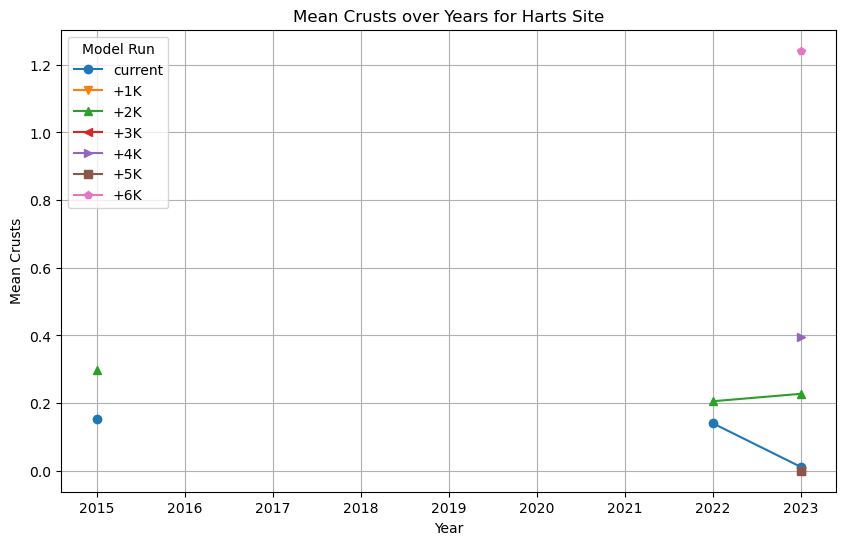

In [10]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Define a list of markers
markers = ['o', 'v', '^', '<', '>', 's', 'p', '*', 'h', 'H', '+', 'x', 'D', 'd', '|', '_']

# Filter the dataset for the 'harts' site
ds_harts = ds.sel(site='harts')

# Get the unique 'model_run' values
model_runs = ds_harts.model_run.values

# Create a new figure
plt.figure(figsize=(10, 6))

# Loop over the unique 'model_run' values
for i, model_run in enumerate(model_runs):
    # Select the 'mean_crusts' variable for the current 'model_run'
    mean_crusts = ds_harts['mean_crusts'].sel(model_run=model_run)

    # Convert the time dimension to years for the x-axis
    years = mean_crusts.time.dt.year

    # Plot the data with a different marker for each 'model_run'
    plt.plot(years, mean_crusts, marker=markers[i % len(markers)], label=model_run)

# Add labels and a legend
plt.xlabel('Year')
plt.ylabel('Mean Crusts')
plt.title('Mean Crusts over Years for Harts Site')
plt.legend(title='Model Run')
plt.grid(True)

# Show the plot
plt.show()